# Procesamiento de imágenes · Tarea 6

En esta tarea aplicaremos lo aprendido sobre procesamiento morfológico, incluyendo dilatación, erosión y _region growing_.

### Importante
* Lee atentamente las instrucciones y todo el código.
* Ejecuta las celdas en orden.
* Escribe tu código en las celdas que lo soliciten.
* Usa los nombres de variables que te pidan.
* Confirma que tu código esté correcto corriendo las celdas que dicen "Chequeo".
* Si el chequeo alerta que hay alguna variable incorrecta, vuelve atrás y arréglala. No hay penalización por esto.

## Configuración inicial

##### Importamos librerías

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import checker
import importlib

##### Aumentamos el tamaño de las imágenes

In [2]:
plt.rcParams['figure.dpi'] = 200

## Parte 1 · _Region growing_ para una imagen binaria

Comencemos con una pequeña imagen binaria de un corazón.

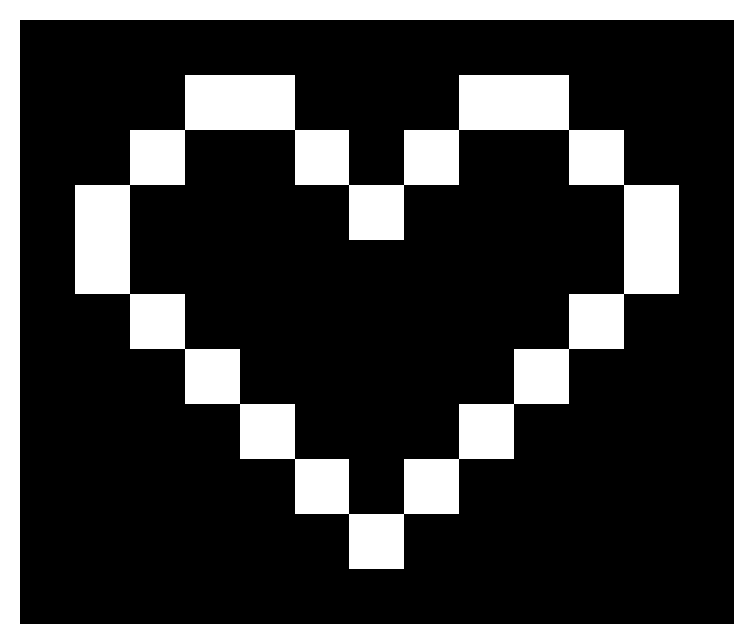

In [3]:
img_pixel = np.zeros((11, 13), dtype=np.uint8)

coords = ((1,3), (1,4), (1, 8), (1, 9), (2, 2), (2, 5),
          (2, 7), (2, 10), (3, 1), (3, 6), (3, 11), (4, 1),
          (4, 11), (5, 2), (5, 10), (6, 3), (6, 9), (7, 4),
          (7, 8), (8, 5), (8, 7), (9, 6))

img_pixel[tuple(zip(*coords))] = 1

plt.imshow(img_pixel, cmap='gray')
plt.axis('off');

En clases vimos un algoritmo de _region growing_ que dilata un pixel semilla para ir rellenando el área dentro de un perímetro.

Implementa este algoritmo en la función ```region_growing_morphology```, recibiendo una imagen binaria (como ```img_pixel```) y las coordenadas del pixel semilla como una tupla ```(y, x)```. Debe retornar una imagen donde los pixeles dentro del perímetro valgan uno y el resto cero. El perímetro debe valer cero. Como no llegaremos a los bordes de la imagen, no te preocupes por esos casos extremos.

In [4]:
# Escribe tu código en las siguientes líneas


def region_growing_morphology(img, seed):
    # Copiamos la imagen original para no modificarla
    img_out = img.copy()
    
    # Definimos el valor de umbral para la inundación de regiones
    th = 0
    
    # Definimos el color de relleno para la inundación
    fill_color = 1
    
    # Definimos la máscara de inundación, que tendrá el mismo tamaño que la imagen de entrada
    mask = np.zeros((img.shape[0]+2, img.shape[1]+2), dtype=np.uint8)
    
    # Inundamos la región a partir del pixel semilla usando la función cv2.floodFill()
    cv2.floodFill(img_out, mask, seed, newVal=fill_color, loDiff=th, upDiff=th)
    
    # Obtenemos los contornos externos de la imagen usando la función cv2.findContours()
    contours, hierarchy = cv2.findContours(img_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Creamos una máscara vacía para el perímetro
    perimeter_mask = np.zeros_like(img_out)
    
    # Dibujamos los contornos externos en la máscara del perímetro
    cv2.drawContours(perimeter_mask, contours, -1, 1, 1)
    
    # Establecemos el valor del perímetro en cero en la imagen de salida
    img_out[perimeter_mask==1] = 0
    
    return img_out
      


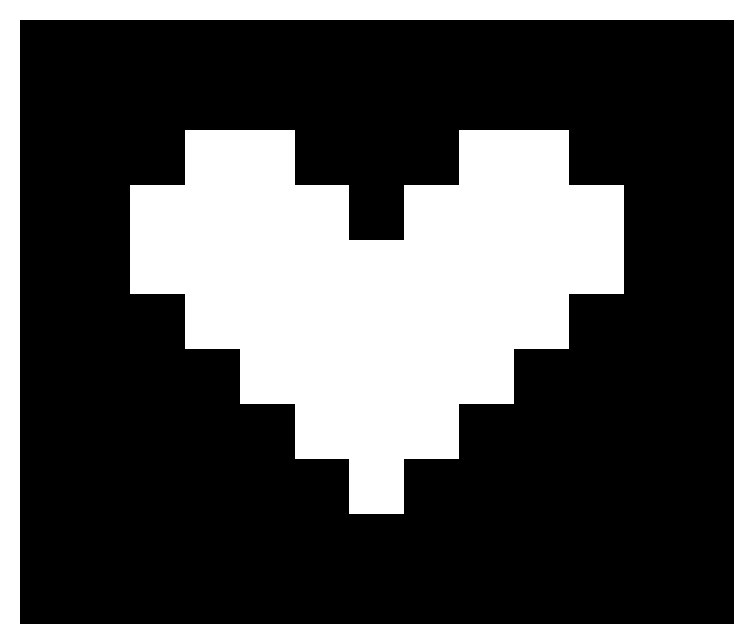

In [5]:
region_pixel = region_growing_morphology(img_pixel, (5, 5))

plt.imshow(region_pixel, cmap='gray')
plt.axis('off');

##### Chequeo

In [6]:
importlib.reload(checker)
assert checker.check_region_pixel(region_pixel)

Relleno correcto. ¡Puedes seguir adelante!


## Parte 2 · Segmentación de imágenes a color

Tenemos una foto de una apetitosa ensalada de fruta y queremos extraer una frambuesa y una uva. Estas están señaladas en la imagen a color.

In [7]:
img_fruit_path = 'fruit.png'
img_fruit = cv2.imread(img_fruit_path, cv2.IMREAD_COLOR)

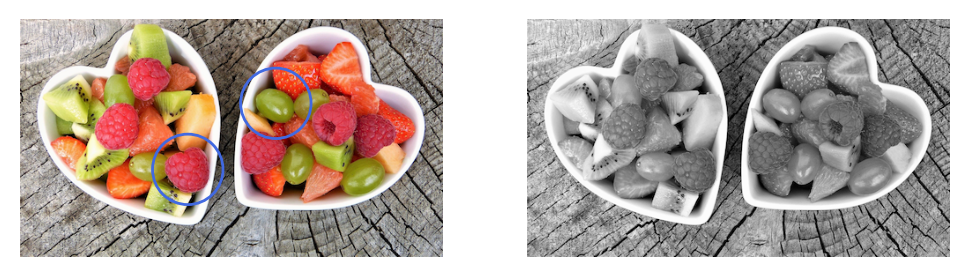

In [8]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(cv2.cvtColor(img_fruit, cv2.COLOR_BGR2RGB))
circle = plt.Circle((190, 170), 40, color='royalblue', fill=False)
axs[0].add_patch(circle)
circle = plt.Circle((290, 95), 40, color='royalblue', fill=False)
axs[0].add_patch(circle)
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(img_fruit, cv2.COLOR_BGR2GRAY), cmap='gray')
axs[1].axis('off');

La imagen en escala de grises no pareciera ser favorable para segmentar las frutas. Veamos cómo se ve cada canal por separado.

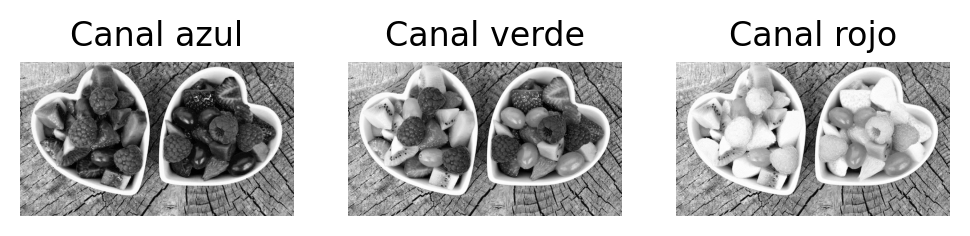

In [9]:
plt.subplot(1, 3, 1)
plt.imshow(img_fruit[:, :, 0], cmap='gray')
plt.axis('off')
plt.title('Canal azul')

plt.subplot(1, 3, 2)
plt.imshow(img_fruit[:, :, 1], cmap='gray')
plt.axis('off')
plt.title('Canal verde')

plt.subplot(1, 3, 3)
plt.imshow(img_fruit[:, :, 2], cmap='gray')
plt.axis('off')
plt.title('Canal rojo');

En el canal azul hay un bajo contraste entre las frutas. En el verde y rojo se ven mayores diferencias.

Podemos crear una nueva imagen a partir de la suma ponderada de los canales. A través de ensayo y error se encuentra una combinación que exhibe un gran contraste entre las distintas frutas. Es importante notar que los pixeles de la imagen ya no estarán entre 0 y 255.

In [10]:
img_fruit_new = img_fruit.astype(np.int16)
img_fruit_new = (img_fruit_new[:, :, 0] + img_fruit_new[:, :, 2] - 2*img_fruit_new[:, :, 1])

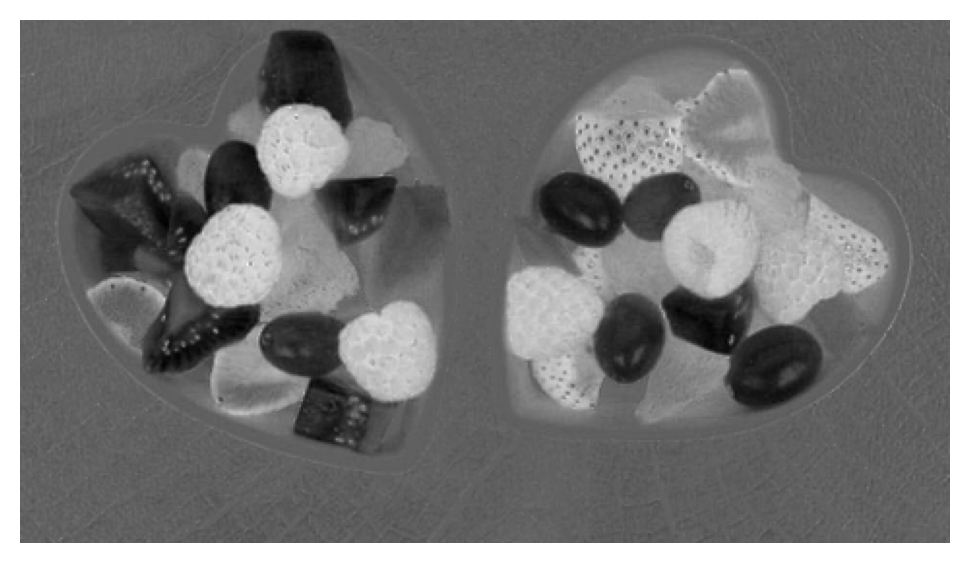

In [11]:
plt.subplot(1, 1, 1)
plt.imshow(img_fruit_new, cmap='gray')
plt.axis('off');

Las dos frutas que queremos extraer tienen un tono de gris distinto al de sus alrededores, lo que nos facilitará el trabajo que sigue.

Veamos qué pasa cuando intentamos segmentar las frutas con umbrales globales.

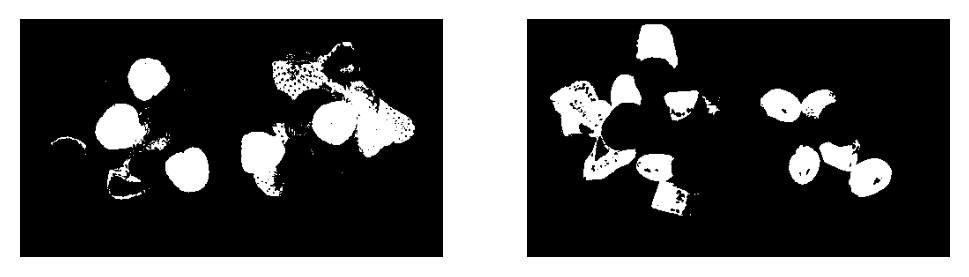

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(img_fruit_new > 100, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_fruit_new < -50, cmap='gray')
plt.axis('off');

Las frutas que queremos extraer se segmentan medianamente bien, pero obviamente no son lo único presente en la imagen. Necesitamos una estrategia distinta. Utilicemos un algoritmo de _region growing_ que nos permita obtener los pixeles conectados y con tono de gris similar a un pixel semilla.

Implementa el algoritmo de _region growing_ en la función ```region_growing_grayscale```. Esta debe recibir una imagen en escala de grises, las coordenadas de un pixel semilla ```(y, x)``` y un _threshold_. Debe hacer crecer el pixel semilla, agregando todo pixel _[4-connected](https://en.wikipedia.org/wiki/Pixel_connectivity#4-connected)_ cuyo valor se diferencie en menos de ```threshold``` al pixel semilla. Debe retornar una imagen donde los pixeles pertenecientes a la región valgan uno y el resto cero. Como no llegaremos a los bordes de la imagen, no te preocupes por esos casos extremos.

En [este](https://en.wikipedia.org/wiki/Flood_fill) artículo puedes encontrar el pseudo-código de algoritmos que podrían ayudarte.

In [13]:
# Escribe tu código en las siguientes líneas
def region_growing_grayscale(img, seed, threshold):
    """
    Crecimiento de regiones a partir de un pixel semilla en una imagen en escala de grises.

    Args:
    - img: np.array, imagen en escala de grises.
    - seed: tuple (y, x), coordenadas del pixel semilla.
    - threshold: int, umbral de diferencia de valores para considerar si un pixel es parte de la región.

    Returns:
    - np.array, matriz binaria de la región encontrada.
    """

    # Creamos una matriz de ceros del mismo tamaño que la imagen original.
    region = np.zeros_like(img, dtype=np.uint8)

    # Marcamos el pixel semilla en la matriz como parte de la región.
    region[seed] = 1

    # Agregamos el pixel semilla a la lista de pixeles por procesar.
    pixels_por_procesar = [seed]

    # Mientras la lista de pixeles por procesar no esté vacía.
    while len(pixels_por_procesar) > 0:

        # Tomamos el primer pixel de la lista.
        pixel_actual = pixels_por_procesar.pop(0)

        # Revisamos los vecinos 4-conectados.
        for vecino in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            y, x = pixel_actual[0] + vecino[0], pixel_actual[1] + vecino[1]

            # Si el vecino no ha sido procesado y su diferencia de valor con el pixel semilla es menor al threshold.
            if (y >= 0 and y < img.shape[0] and x >= 0 and x < img.shape[1] and region[y, x] == 0 and abs(img[y, x] - img[seed]) <= threshold):

                # Lo marcamos en la matriz como parte de la región.
                region[y, x] = 1

                # Lo agregamos a la lista de pixeles por procesar.
                pixels_por_procesar.append((y, x))

    # Retornamos la matriz de la región.
    return region

Segmentemos la frambuesa con el algoritmo. El pixel semilla está en (170, 190) y usaremos un _threshold_ igual a 60.

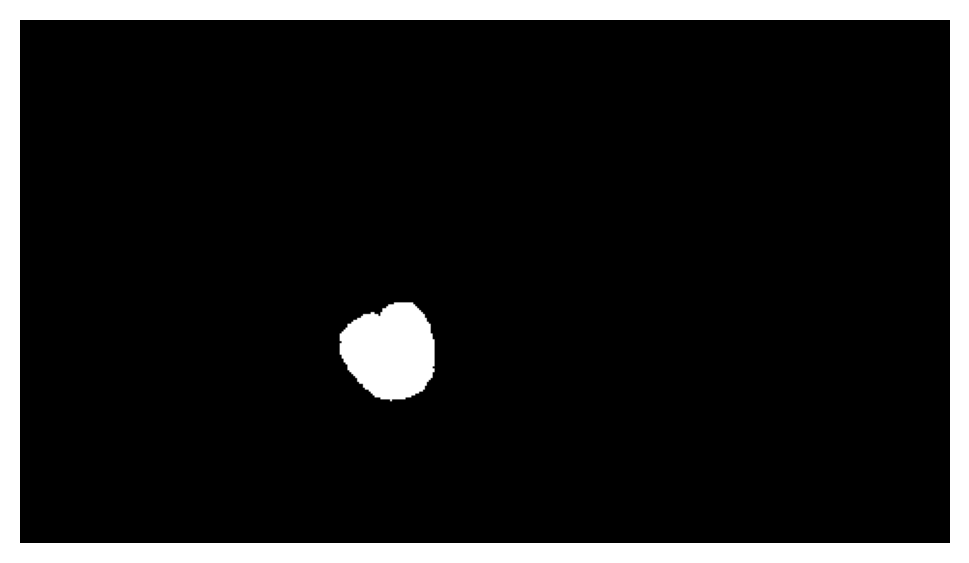

In [14]:
mask_raspberry = region_growing_grayscale(img_fruit_new, (170, 190), 60)

plt.imshow(mask_raspberry, cmap='gray')
plt.axis('off');

Si el algoritmo funciona correctamente, deberías ver la forma de la frambuesa en blanco.

##### Chequeo

In [15]:
importlib.reload(checker)
assert checker.check_mask_raspberry(mask_raspberry)

Máscara correcta. ¡Puedes seguir adelante!


Repitamos lo mismo para la uva y veamos cómo nos va.

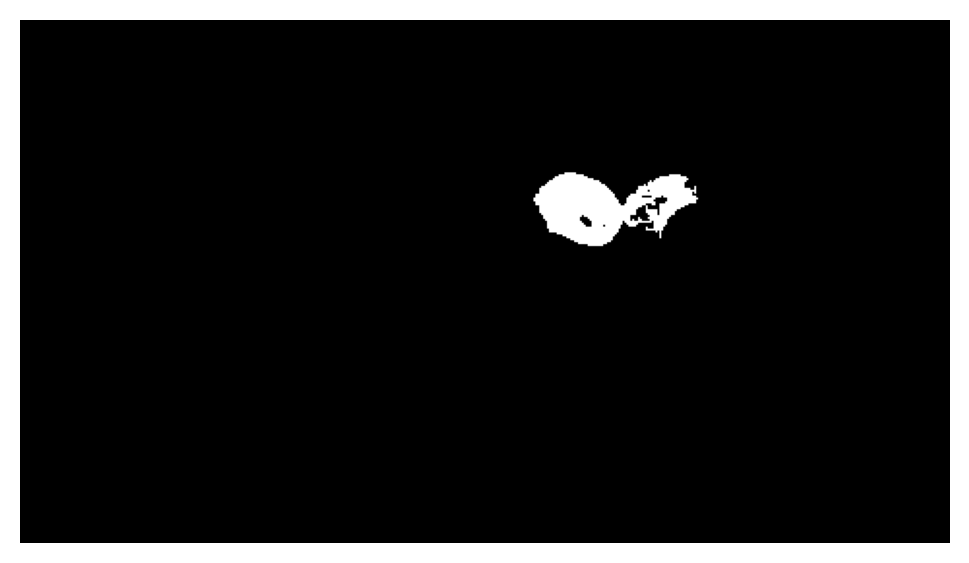

In [16]:
mask_grape = region_growing_grayscale(img_fruit_new, (100, 295), 60)

plt.imshow(mask_grape, cmap='gray')
plt.axis('off');

Como hay una uva de un color similar al lado de la que queremos segmentar, esta también fue incluida en la máscara. Bajemos el umbral a 30.

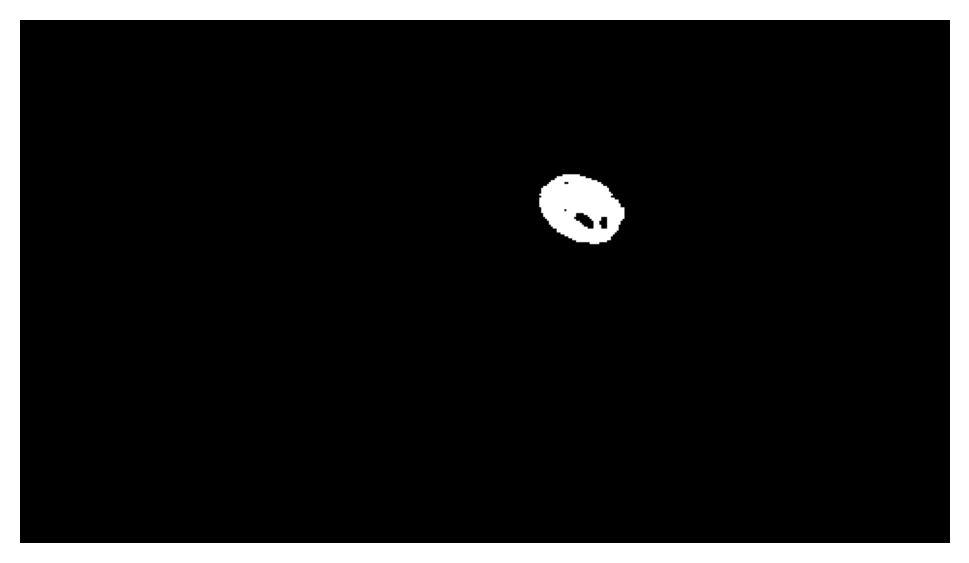

In [17]:
mask_grape = region_growing_grayscale(img_fruit_new, (100, 295), 30)

plt.imshow(mask_grape, cmap='gray')
plt.axis('off');

Logramos eliminar la segunda uva pero ahora faltó parte de la primera. Como vimos en clases, podemos rellenar agujeros realizando primero una dilatación y después una erosión.

Cierra los agujeros aplicando tres dilataciones y luego tres erosiones. Guarda el resultado en ```mask_grape_filled```. Usa las funciones de [aquí](https://docs.scipy.org/doc/scipy/reference/ndimage.html#morphology).

True

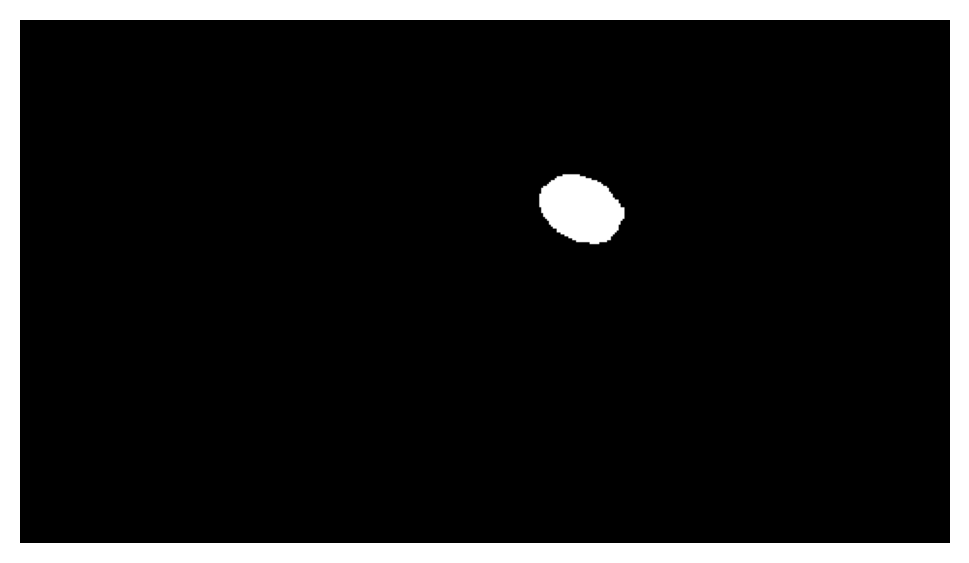

In [18]:
# Escribe tu código en las siguientes líneas
# Definir el kernel de la operación de dilatación y erosión
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Aplicar tres dilataciones
mask_grape_dilated = cv2.dilate(mask_grape, kernel, iterations=3)

# Aplicar tres erosiones
mask_grape_eroded = cv2.erode(mask_grape_dilated, kernel, iterations=3)

# Mostrar la imagen resultante
plt.imshow(mask_grape_eroded, cmap='gray')
plt.axis('off');

# Guardar la imagen en un archivo
mask_grape_filled = mask_grape_eroded
cv2.imwrite('mask_grape_filled.png', mask_grape_filled * 255)

In [19]:
# Transformamos a 0 y 1
mask_grape_filled = mask_grape_filled.astype(np.uint8)

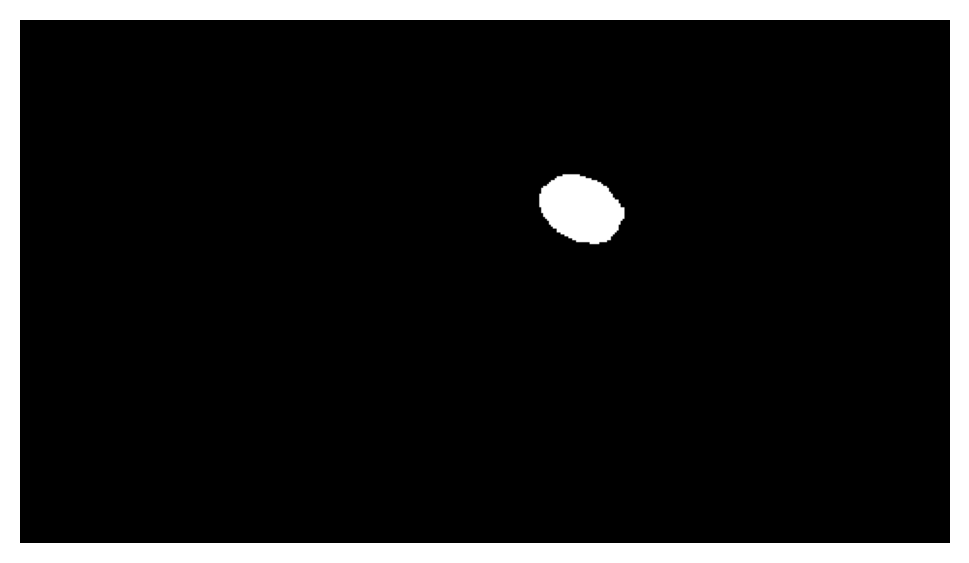

In [20]:
plt.imshow(mask_grape_filled, cmap='gray')
plt.axis('off');

##### Chequeo

In [21]:
importlib.reload(checker)
assert checker.check_mask_grape_filled(mask_grape_filled)

Máscara correcta. ¡Puedes seguir adelante!


Finalmente, apliquemos las máscaras obtenidas a la imagen a color original para obtener una imagen que solo incluya las dos frutas a color. Ya hemos hecho esto en tareas pasadas. Guarda el resultado en ```img_fruit_masked```. Debe ser un arreglo tridimensional compuesto por ```uint8``` entre 0 y 255.

In [22]:
# Escribe tu código en las siguientes líneas
# Aplicar las máscaras obtenidas a la imagen a color original
mask_fruit = mask_raspberry + mask_grape_filled

# Crear una máscara adicional para excluir la parte no deseada de la uva
mask_grape_only = np.zeros_like(mask_grape_filled)
mask_grape_only[50:240, 180:340] = 1

# Aplicar la máscara adicional a la máscara de la uva
mask_grape = cv2.bitwise_and(mask_grape_filled, mask_grape_only)

##plt.imshow(mask_grape, cmap='gray')
##plt.title('Imagen binaria con el avión segmentadooo')
##plt.axis('off');

# Crear una copia de la imagen original para aplicar las máscaras
img_fruit_masked = img_fruit.copy()

# Aplicar las máscaras a los canales RGB de la imagen copiada
img_fruit_masked[:, :, 0][mask_fruit == 0] = 0
img_fruit_masked[:, :, 1][mask_fruit == 0] = 0
img_fruit_masked[:, :, 2][mask_fruit == 0] = 0
##img_fruit_masked[:, :, 0][mask_grape == 1] = 0

#############
##plt.imshow(mask_raspberry, cmap='gray')
##plt.title('Imagen binaria con el avión segmentado')
##plt.axis('off');



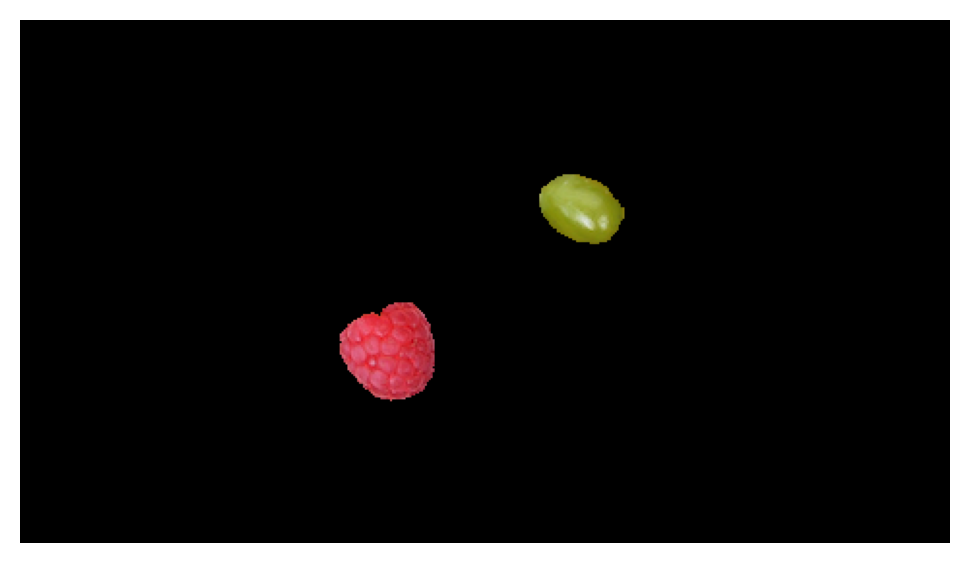

In [23]:
plt.subplot(1, 1, 1)
plt.imshow(img_fruit_masked[:, :, ::-1])
plt.axis('off');

##### Chequeo

In [24]:
importlib.reload(checker)
assert checker.check_img_fruit_masked(img_fruit_masked)

Imagen correcta. ¡Puedes seguir adelante!


¡Fantástico! Aprendiste a rellenar el interior de un perímetro y lograste segmentar dos frutas usando operaciones morfológicas.

## Chequeo final

La siguiente función revisará si los valores están correctos corriendo los mismos chequeos que antes.

Recuerda presionar _Validate_ arriba para que la plataforma corra todos los tests.

In [25]:
importlib.reload(checker)
assert checker.check_all(region_pixel, mask_raspberry, mask_grape_filled, img_fruit_masked)

Chequeando region_pixel
Relleno correcto. ¡Puedes seguir adelante!
Chequeando mask_raspberry
Máscara correcta. ¡Puedes seguir adelante!
Chequeando mask_grape_filled
Máscara correcta. ¡Puedes seguir adelante!
Chequeando img_fruit_masked
Imagen correcta. ¡Puedes seguir adelante!

¡Felicitaciones! ¡Lograste completar el programa!
